In [1]:
print('hello')

hello


In [ ]:
!pip install pandas

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from skimage.measure import label

TRAIN_DIR = "../data/train/"
TEST_DIR = "../data/test/"


### Phan tich du lieu ban dau

In [ ]:
def analyze_dataset(data_dir, dataset_name="Train"):
    print(f"--- Đang phân tích tập dữ liệu: {dataset_name} ---")
    
    image_ids = next(os.walk(data_dir))[1]
    num_images = len(image_ids)
    print(f"Tổng số ảnh: {num_images}")
    
    widths = []
    heights = []
    nuclei_counts = []
    
    sample_ids = np.random.choice(image_ids, 3, replace=False)
    samples = []

    for id_ in tqdm(image_ids, desc="Processing images"):
        path = os.path.join(data_dir, id_)
        img_path = os.path.join(path, 'images', id_ + '.png')
        mask_dir = os.path.join(path, 'masks')
        
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                h, w, _ = img.shape
                widths.append(w)
                heights.append(h)
                
                # Nếu là mẫu visualize, lưu lại
                if id_ in sample_ids:
                    # Đọc và gộp mask
                    mask = np.zeros((h, w), dtype=np.uint8)
                    if os.path.exists(mask_dir):
                        for mask_file in next(os.walk(mask_dir))[2]:
                            m = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
                            mask = np.maximum(mask, m)
                    samples.append((id_, cv2.cvtColor(img, cv2.COLOR_BGR2RGB), mask))

        if os.path.exists(mask_dir):
            num_nuclei = len(next(os.walk(mask_dir))[2])
            nuclei_counts.append(num_nuclei)
            
    # --- VẼ BIỂU ĐỒ ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Phân bố Chiều rộng
    axes[0].hist(widths, bins=20, color='skyblue', edgecolor='black')
    axes[0].set_title(f'{dataset_name} - Image Width Distribution')
    axes[0].set_xlabel('Width (pixels)')
    axes[0].set_ylabel('Count')
    
    # 2. Phân bố Chiều cao
    axes[1].hist(heights, bins=20, color='salmon', edgecolor='black')
    axes[1].set_title(f'{dataset_name} - Image Height Distribution')
    axes[1].set_xlabel('Height (pixels)')
    
    # 3. Phân bố Số lượng nhân tế bào
    if nuclei_counts:
        axes[2].hist(nuclei_counts, bins=30, color='lightgreen', edgecolor='black')
        axes[2].set_title(f'{dataset_name} - Nuclei Count per Image')
        axes[2].set_xlabel('Number of Nuclei')
    else:
        axes[2].text(0.5, 0.5, "No masks found", ha='center')
        
    plt.tight_layout()
    plt.show()
    
    print(f"Kích thước ảnh phổ biến: {max(set(widths), key=widths.count)}x{max(set(heights), key=heights.count)}")
    if nuclei_counts:
        print(f"Số lượng nhân trung bình/ảnh: {np.mean(nuclei_counts):.1f}")
        print(f"Số lượng nhân nhiều nhất: {np.max(nuclei_counts)}")
        print(f"Số lượng nhân ít nhất: {np.min(nuclei_counts)}")

    return samples

In [ ]:
def visualize_samples_row(samples):
    if not samples or len(samples) < 2:
        print("Cần ít nhất 2 mẫu để hiển thị.")
        return

    batch_samples = samples[:2]

    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    
    for i, (id_, img, mask) in enumerate(batch_samples):
        ax_orig = axes[2*i]
        ax_orig.imshow(img)
        ax_orig.set_title(f"Original Image #{i+1}\nID: {id_}")
        ax_orig.axis('off')

        ax_mask = axes[2*i + 1]
        
        colored_mask = np.zeros_like(img)
        colored_mask[mask > 0] = [255, 255, 0] # Màu vàng
        overlay = cv2.addWeighted(img, 0.7, colored_mask, 0.3, 0)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2) # Viền xanh lá
        
        ax_mask.imshow(overlay)
        ax_mask.set_title(f"Ground Truth #{i+1}\nNuclei: {len(contours)}")
        ax_mask.axis('off')
        
    plt.tight_layout()
    plt.show()

### Hien thi thong tin du lieu

--- Đang phân tích tập dữ liệu: Train Data ---
Tổng số ảnh: 670


Processing images: 100%|██████████| 670/670 [00:05<00:00, 127.08it/s]


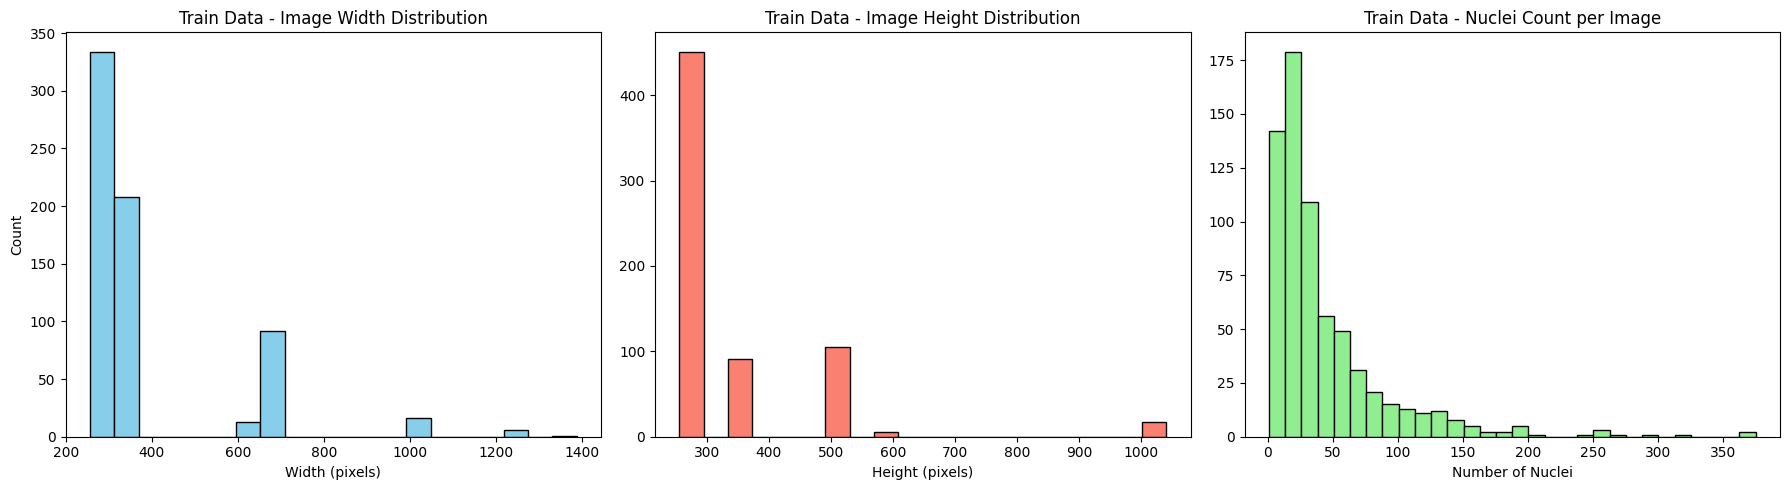

Kích thước ảnh phổ biến: 256x256
Số lượng nhân trung bình/ảnh: 44.0
Số lượng nhân nhiều nhất: 375
Số lượng nhân ít nhất: 1


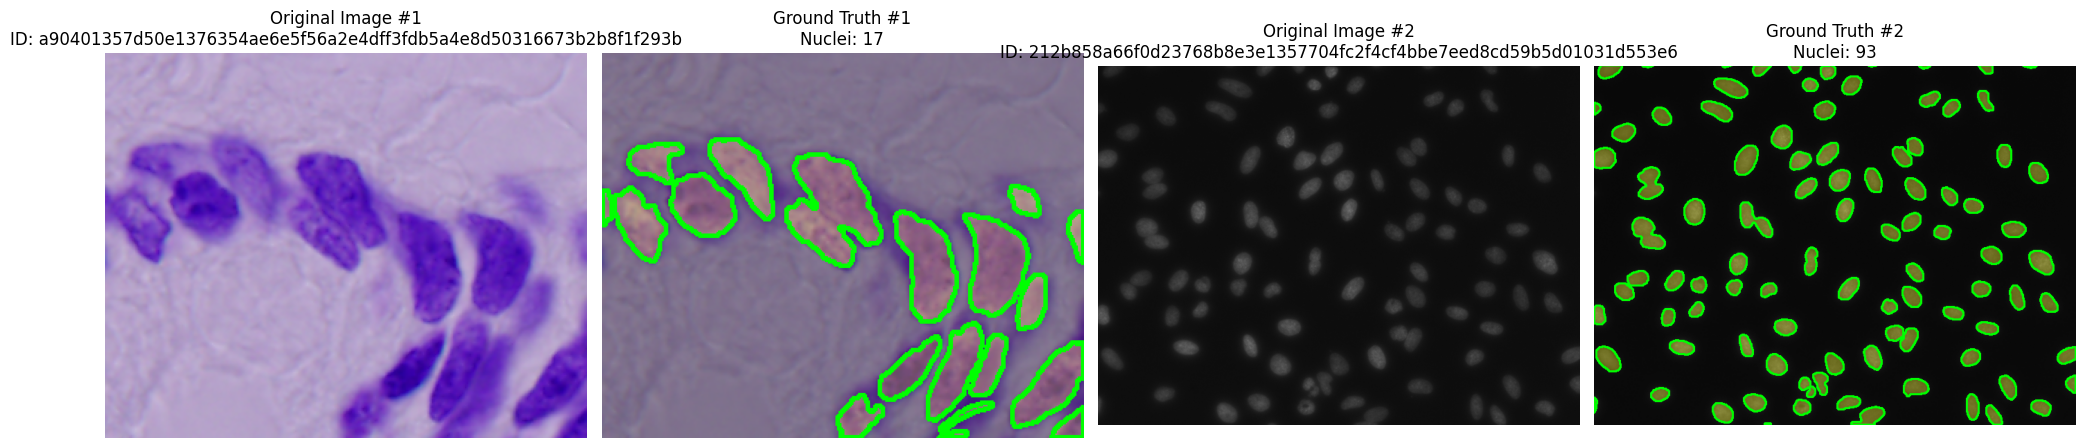

In [8]:
visualize_samples_row(analyze_dataset(TRAIN_DIR, "Train Data"))

### EDA cac dac trung nang cao


In [ ]:
!pip install seaborn

--- 🔬 Đang phân tích đặc trưng nâng cao ---


100%|██████████| 50/50 [00:03<00:00, 16.00it/s]


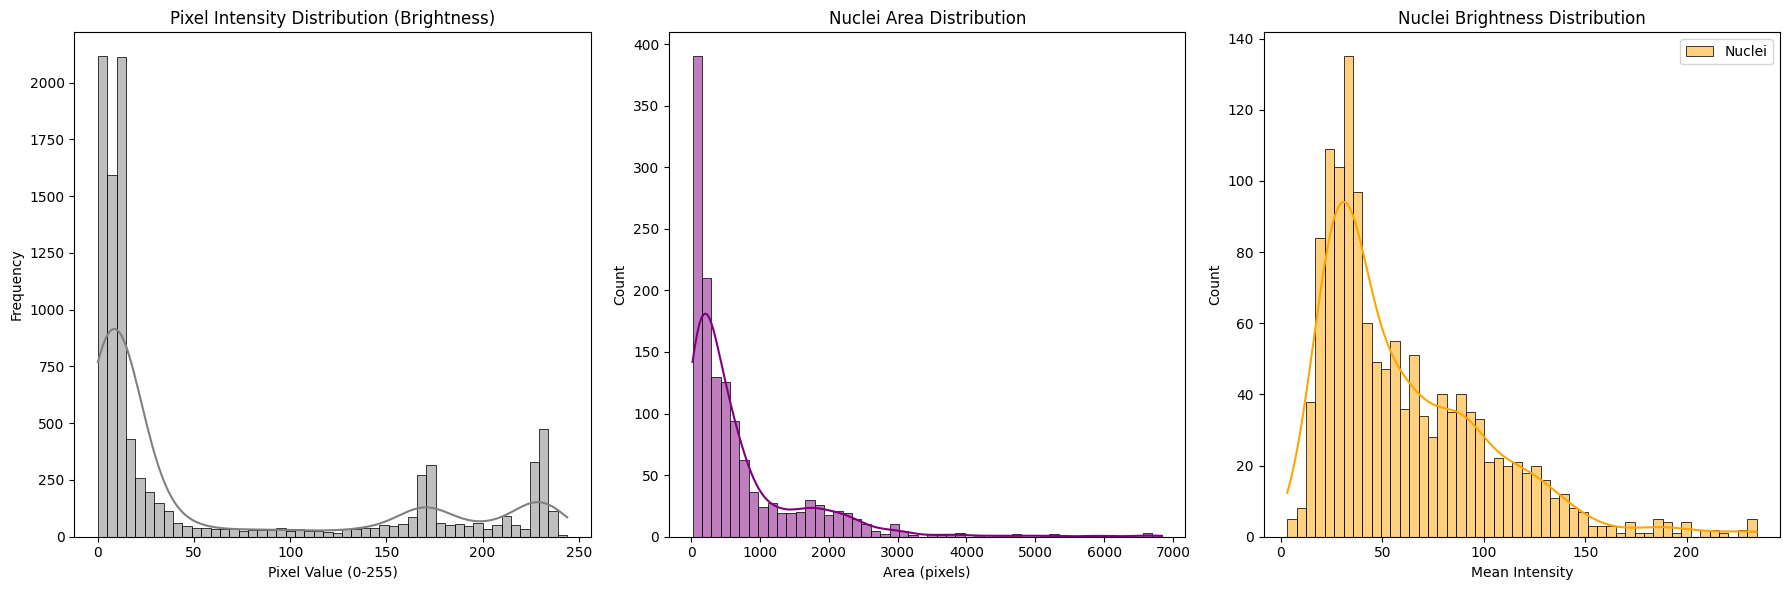


--- THỐNG KÊ CHI TIẾT ---
• Diện tích nhân trung bình: 696.0 pixels
• Diện tích nhỏ nhất: 21.0 | Lớn nhất: 6838.0
• Độ sáng trung bình toàn ảnh: 59.2


In [ ]:
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import seaborn as sns  
import cv2
import os
import numpy as np
from tqdm import tqdm

def analyze_advanced_features(data_dir):
    print("--- 🔬 Đang phân tích đặc trưng nâng cao ---")
    
    image_ids = next(os.walk(data_dir))[1]
    
    # Danh sách chứa dữ liệu thống kê
    all_nuclei_areas = []      # Diện tích từng nhân (số pixel)
    all_image_intensities = [] # Độ sáng trung bình của ảnh
    nuclei_intensities = []    # Độ sáng trung bình của nhân tế bào
    
    # Chỉ lấy mẫu khoảng 50 ảnh để chạy cho nhanh (nếu dataset lớn)
    sample_ids = image_ids[:50] if len(image_ids) > 50 else image_ids

    for id_ in tqdm(sample_ids):
        path = os.path.join(data_dir, id_)
        img_path = os.path.join(path, 'images', id_ + '.png')
        mask_dir = os.path.join(path, 'masks')
        
        if os.path.exists(img_path):
            # Đọc ảnh (Grayscale để tính độ sáng)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            all_image_intensities.extend(img.flatten()) # Lưu pixel để vẽ histogram toàn cục
            
            # Đọc Mask để đo tế bào
            if os.path.exists(mask_dir):
                mask = np.zeros_like(img)
                for mask_file in next(os.walk(mask_dir))[2]:
                    m = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
                    # Resize m về kích thước img nếu cần (đề phòng lỗi dữ liệu)
                    if m.shape != img.shape:
                        m = cv2.resize(m, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
                    mask = np.maximum(mask, m)
                
                # Định danh từng tế bào (Labeling)
                labeled_mask = label(mask > 0)
                props = regionprops(labeled_mask, intensity_image=img)
                
                for prop in props:
                    all_nuclei_areas.append(prop.area)
                    nuclei_intensities.append(prop.mean_intensity)

    # --- VẼ BIỂU ĐỒ ---
    plt.figure(figsize=(18, 6))

    # 1. Biểu đồ phân bố giá trị Pixel (Pixel Intensity)
    # Giúp quyết định Normalization (chia 255 hay dùng Percentile)
    plt.subplot(1, 3, 1)
    # Lấy mẫu ngẫu nhiên 10.000 điểm ảnh để vẽ cho nhanh
    sns.histplot(np.random.choice(all_image_intensities, 10000), bins=50, color='gray', kde=True)
    plt.title('Pixel Intensity Distribution (Brightness)')
    plt.xlabel('Pixel Value (0-255)')
    plt.ylabel('Frequency')

    # 2. Biểu đồ Diện tích Nhân tế bào (Nuclei Area)
    # Giúp biết tế bào to hay nhỏ
    plt.subplot(1, 3, 2)
    sns.histplot(all_nuclei_areas, bins=50, color='purple', kde=True)
    plt.title('Nuclei Area Distribution')
    plt.xlabel('Area (pixels)')
    plt.ylabel('Count')

    # 3. Biểu đồ Độ sáng Nhân vs Nền
    # So sánh độ sáng
    plt.subplot(1, 3, 3)
    sns.histplot(nuclei_intensities, bins=50, color='orange', label='Nuclei', kde=True)
    plt.title('Nuclei Brightness Distribution')
    plt.xlabel('Mean Intensity')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # In thông số thống kê
    print(f"\n--- THỐNG KÊ CHI TIẾT ---")
    print(f"• Diện tích nhân trung bình: {np.mean(all_nuclei_areas):.1f} pixels")
    print(f"• Diện tích nhỏ nhất: {np.min(all_nuclei_areas)} | Lớn nhất: {np.max(all_nuclei_areas)}")
    print(f"• Độ sáng trung bình toàn ảnh: {np.mean(all_image_intensities):.1f}")

# Chạy hàm (Đảm bảo biến TRAIN_DIR đã được định nghĩa ở cell trước)
if 'TRAIN_DIR' in locals():
    analyze_advanced_features(TRAIN_DIR)
else:
    print("Vui lòng định nghĩa TRAIN_DIR trước (ví dụ: 'data/train/')")